 # Collaborative Latent-Factors-Based Filtering for Movie Recommendations

## Introduction

The latent factor approach in recommendation systems utilizes matrix factorization techniques to uncover hidden patterns in user-item interactions. These methods predict user preferences by mapping both users and items to a shared latent space where their interactions can be represented by their proximity or alignment. Latent factor models, such as Singular Value Decomposition (SVD), are widely used in this context.

Key features of the latent factor approach:
- Captures underlying relationships between users and items.
- Handles sparse datasets effectively by reducing dimensionality.
- Improves scalability compared to neighborhood-based methods.

In this notebook, we will explore the latent factor approach to build a movie recommendation system using matrix factorization.

### Mathematical Background

The latent factor approach works by:
- Represent users and items in a shared lower dimensional latent space (ie, as a vector of latent factors).
- Such vectros are inferred (ie, learned) from the observed ratings.
- High correlation between user and item latent factors indicates a possible recomendation.
- Map both users and items to the latent space and then predict ratings based on the inner product in the latent space.

So formally we have:
- $\vec x_u \in R^d$ is the latent factor vector for user $u$. Each $\vec x_u[k] \in R$ measure the extent of interest user $u$ has in items exhibiting latent factor $k$.
- $\vec w_i \in R^d$ is the latent factor vector for item $i$. Each $\vec w_i[k] \in R$ measure the extent of interest item $i$ has in users exhibiting latent factor $k$.

Essentially, $d$ hidden features to describe both users and items.

Thus, $r_{u,i}$ is the rating given by user $u$ to item $i$ and $\hat{r}_{u,i} = \vec x_u \cdot \vec w_i = \sum_{k=1}^d \vec x_u[k] \cdot \vec w_i[k]$ is the predicted rating for user $u$ and item $i$.

The problem is to approximate the user-item matrix $R \in \mathbb R^{m \times n}$ with the product of a user latent factor matrix $X \in \mathbb R^{m \times d}$ and an item latent factor matrix $W^T \in \mathbb R^{d \times n}$. So

$$
R \approx X \cdot W^T.
$$

## Dataset Description

We use two datasets for this analysis:

1. **Movies Dataset**:
   - `Movie_ID`: Unique identifier for each movie.
   - `Title`: Name of the movie.
   - `Year`: Year the movie was released.

2. **Ratings Dataset**:
   - `User_ID`: Unique identifier for each user.
   - `Movie_ID`: Identifier for the movie rated by the user.
   - `Rating`: Numeric rating provided by the user (e.g., on a scale of 1-5).

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Load the dataset
ratings = pd.read_csv("./data/Netflix_Dataset_Rating.csv")  # Columns: User_ID, Rating, Movie_ID
movies  = pd.read_csv("./data/Netflix_Dataset_Movie.csv")    # Columns: Movie_ID, Year, Name

### Formal Definition

- $U = \{u_1, u_2, \dots, u_n\}$ is the set of users.
- $U_i = \{u \in U \mid r_{u,i} \neq 0\}$ is the set of users who have rated item $i$
- $I = \{i_1, i_2, \dots, i_m\}$ is the set of items.
- $I_u = \{i \in I \mid r_{u,i} \neq 0\}$ is the set of items rated by user $u$
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $r_{u,i}$ is the rating given by user $u$ for item $i$ (equal to 0 if not rated).
- $D = \{(u_j, i_j)\}_{j=1}^{N}$ is the set of user-item pairs (our dataset).
- $I_D = \{i \in I \mid \exists (u, i) \in D\}$ is the set of items in the dataset.
- $U_D = \{u \in U \mid \exists (u, i) \in D\}$ is the set of users in the dataset.

## User-Based Collaborative Filtering

### 1. Data Preprocessing
- **User-Item Matrix Creation**: Convert the ratings dataset into a user-item matrix, where rows represent users and columns represent movies. Missing ratings are filled with zeros. Each rating is represented by a number from 1 to 5.
  $$ M[u, i] = r_{u,i} \in R$$
  Where:
  - $u \in U$ is the set of users.
  - $i \in I$ is the set of movies.
  - $r_{u,i}$ is the rating given by user $u$ for movie $i$.

- **Sparse Matrix Conversion**: The dense matrix is converted to a sparse format for memory optimization:
  $$M_{\{\text{sparse}\}} = \text{sparse}(M)$$

In [2]:
# Step 1: Create a user-item matrix
user_item_matrix = ratings.pivot(index='User_ID', columns='Movie_ID', values='Rating')

# Fill missing values with 0 (can use NaN for some algorithms)
user_item_matrix.fillna(0, inplace=True) # It is not the case for this dataset

# Convert the DataFrame to a sparse matrix
sparse_user_item = csr_matrix(user_item_matrix.values)

### 2. Determine the Loss Function and Computing Its Gradient

Assuming we have access to the dataset $D$ of observed atings, the matrix $R$ is partially known and filled with those observations. To actully learn the latent factors, we need to choose a loss function to optimize. In our case, we choose squared error (SE):

$$
L(X, W) = \frac{1}{2} \left[ \sum_{(u, i) \in D} (r_{u,i} - \hat{r}_{u,i})^2 + \lambda (\sum_{u \in U_D} \|\vec x_u\|^2 + \sum_{i \in I_D} \|\vec w_i\|^2)\right]
$$

Thus, 

$$X^*, W^* = \argmin_{X, W} \ L(X, W).$$

#### Loss Function
The loss function in, matrix notation, is defined in terms of matrices as:
$$
L(X, W) = \frac{1}{2} \left[ \| R - X W^T \|_F^2 + \lambda \left( \|X\|_F^2 + \|W\|_F^2 \right) \right],
$$
where:
- $R \in \mathbb{R}^{m \times n}$ is the observed rating matrix, with $R_{u,i} = r_{u,i}$ if user $u$ has rated item $i$, and 0 otherwise.
- $X \in \mathbb{R}^{m \times d}$ represents the user latent factors (each row corresponds to a user vector $X_u$).
- $W \in \mathbb{R}^{n \times d}$ represents the item latent factors (each row corresponds to an item vector $W_i$).
- $\| \cdot \|_F$ is the Frobenius norm.

The prediction matrix is:
$$
\hat{R} = X W^T.
$$

The loss consists of:
1. The reconstruction error:
$$
\| R - X W^T \|_F^2 = \sum_{(u, i) \in D} (r_{u,i} - X_u W_i^T)^2.
$$
2. The regularization terms:
$$
\lambda \left( \|X\|_F^2 + \|W\|_F^2 \right).
$$

---

#### Computing the Gradients

##### Gradient with respect to $X$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial X} \frac{1}{2} \| R - X W^T \|_F^2 = -(R - X W^T) W.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial X} \frac{\lambda}{2} \|X\|_F^2 = \lambda X.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial X} = -(R - X W^T) W + \lambda X.
$$

---

##### Gradient with respect to $W$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial W} \frac{1}{2} \| R - X W^T \|_F^2 = -(R - X W^T)^T X.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial W} \frac{\lambda}{2} \|W\|_F^2 = \lambda W.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial W} = -(R - X W^T)^T X + \lambda W.
$$

In [3]:
# Step 2: Setting up the model parameters

# Hyperparameters
num_factors = 10  # Number of latent factors (k)
learning_rate = 0.01  # Learning rate (eta)
reg_lambda = 0.01  # Regularization term (lambda)
num_epochs = 200  # Number of epochs
gradient_clip = 3.0  # Gradient clipping threshold

# Dimensions of the user-item matrix
num_users, num_items = user_item_matrix.shape

# Initialize latent factor matrices X and W with small random values
X = np.random.normal(scale=0.01, size=(num_users, num_factors))
W = np.random.normal(scale=0.01, size=(num_items, num_factors))

# Create a mask for observed entries in R
R = user_item_matrix.values
mask = R > 0  # Boolean mask for observed entries

# List to store loss values for plotting
loss_history = []

### 3. Optimize the Loss Function with Stochastic Gradient Descent

In order to optimize the loss function, we use Stochastic Gradient Descent (SGD).

#### Explanation of the SGD Algorithm (Matrix Form)

##### 1. Initialization
- Matrices $X$ (users' latent factors) and $W$ (items' latent factors) are initialized randomly with small values.
- $X \in \mathbb{R}^{m \times d}$, where $m$ is the number of users and $d$ is the number of latent factors.
- $W \in \mathbb{R}^{n \times d}$, where $n$ is the number of items.

##### 2. Gradient Computation
- Define the prediction matrix:
  $$
  \hat{R} = X W^T
  $$
- Compute the error matrix (only for observed entries in $R$):
  $$
  E = \begin{cases}
  R_{ui} > 0 \quad R_{ui} - \hat{R}_{ui}\\
  0 \quad \text{otherwise}
  \end{cases},
  $$
  where $E_{ui} = 0$ for unobserved entries of $R$.

- Gradients for $X$ and $W$:
  $$
  \nabla_X = - E W + \lambda X
  $$
  $$
  \nabla_W = - E^T X + \lambda W
  $$

##### 3. Updates
- Update the latent factor matrices $X$ and $W$ simultaneously:
  $$
  X \leftarrow X - \eta \nabla_X
  $$
  $$
  W \leftarrow W - \eta \nabla_W
  $$
- Here, $\eta$ is the learning rate.

##### 4. Loss Tracking
- The total loss for each epoch combines the squared error and the regularization terms:
  $$
  L = \| R - X W^T \|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
  $$
- This tracks the reconstruction error and ensures that the latent factor matrices do not grow too large (controlled by the regularization term).

##### 5. Optimization Loop
- Repeat the following steps for a fixed number of epochs or until the loss converges:
  1. Compute the error matrix $E$.
  2. Compute the gradients $\nabla_X$ and $\nabla_W$ using matrix operations.
  3. Update $X$ and $W$ using the gradients.
  4. Track and print the loss for each epoch.

---

##### Notes
- This implementation only updates $X$ and $W$ for the observed entries of $R$ using matrix masking.
- The hyperparameters ($\eta$, $d$, and $\lambda$) should be tuned based on the dataset for optimal performance.

In [4]:
#4. Start SGD loop

for epoch in range(num_epochs):
    # Compute the predicted matrix
    R_hat = X @ W.T

    # Compute the error matrix for observed entries only
    E = np.multiply(mask, R - R_hat)

    # Compute gradients with regularization
    grad_X = -E @ W + reg_lambda * X
    grad_W = -E.T @ X + reg_lambda * W

    # Apply gradient clipping to avoid exploding updates
    grad_X = np.clip(grad_X, -gradient_clip, gradient_clip)
    grad_W = np.clip(grad_W, -gradient_clip, gradient_clip)

    # Update X and W
    X -= learning_rate * grad_X
    W -= learning_rate * grad_W

    # Compute the total loss
    reconstruction_loss = np.sum(np.multiply(mask, E) ** 2)
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss

    # Append the total loss to the history
    loss_history.append(total_loss)

    # Print the loss for the current epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

    # Check for NaN or Inf values in X or W
    if np.any(np.isnan(X)) or np.any(np.isnan(W)) or np.any(np.isinf(X)) or np.any(np.isinf(W)):
        print("Numerical instability detected. Terminating training.")
        break

    # Debugging: Check mean and std of gradients
    print(f"  Gradient X: mean={np.mean(grad_X):.4f}, std={np.std(grad_X):.4f}")
    print(f"  Gradient W: mean={np.mean(grad_W):.4f}, std={np.std(grad_W):.4f}")

Epoch 1/200
  Reconstruction Loss: 243096275.7051
  Regularization Loss: 1.8235
  Total Loss: 243096277.5286
  Gradient X: mean=0.1942, std=0.4241
  Gradient W: mean=0.2380, std=2.0803
Epoch 2/200
  Reconstruction Loss: 243052708.7914
  Regularization Loss: 13.0051
  Total Loss: 243052721.7965
  Gradient X: mean=0.4536, std=2.5594
  Gradient W: mean=1.7725, std=2.4045
Epoch 3/200
  Reconstruction Loss: 241879541.8932
  Regularization Loss: 42.3811
  Total Loss: 241879584.2743
  Gradient X: mean=1.7978, std=2.3992
  Gradient W: mean=0.9747, std=2.8355
Epoch 4/200
  Reconstruction Loss: 238698839.8264
  Regularization Loss: 96.5574
  Total Loss: 238698936.3839
  Gradient X: mean=1.2099, std=2.7012
  Gradient W: mean=1.7995, std=2.4000
Epoch 5/200
  Reconstruction Loss: 233692218.0405
  Regularization Loss: 172.9153
  Total Loss: 233692390.9558
  Gradient X: mean=1.7980, std=2.3993
  Gradient W: mean=1.2000, std=2.7495
Epoch 6/200
  Reconstruction Loss: 226700038.2517
  Regularization Los

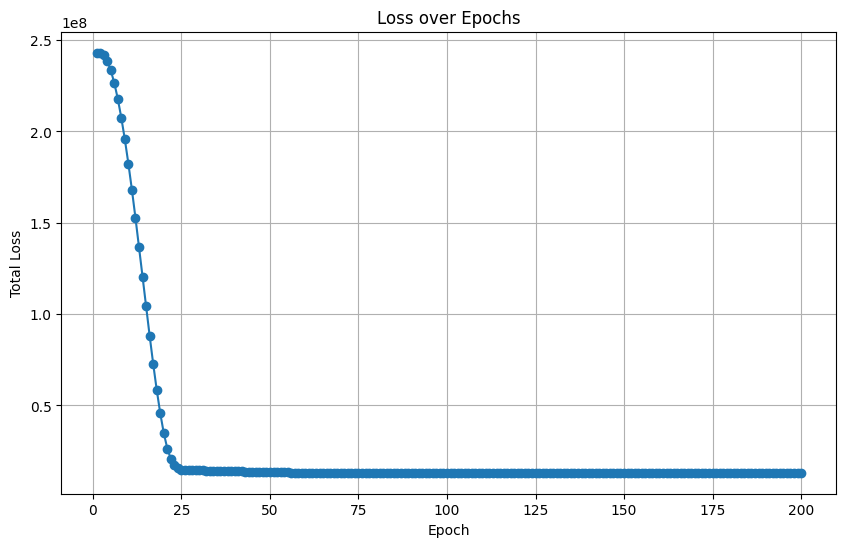

In [5]:
from matplotlib import pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss over Epochs')
plt.grid()
plt.show()

### 4. Model Testing (User-Based)
The function is tested with a sample user to generate personalized recommendations (User-Based).

In [5]:
# Step 4: Test the recommendation function
user_id_to_test = 774868 #1331154  # Change as needed
num_recommendations = 5

try:
    user_based_recommendations = recommend_movies_user_based(user_id_to_test, sparse_user_item, num_recommendations=num_recommendations)
    print(f"Top {num_recommendations} movie recommendations for User {user_id_to_test}:")
    print(user_based_recommendations[['Name', 'Year', 'Estimated_Rating', 'Movie_ID']])
except ValueError as e:
    print(e)

Top 5 movie recommendations for User 774868:
                                                Name  Year  Estimated_Rating  \
0      Lord of the Rings: The Fellowship of the Ring  2001          0.924213   
1  Pirates of the Caribbean: The Curse of the Bla...  2003          0.757490   
2                               Bend It Like Beckham  2002          0.646989   
3                                  Princess Mononoke  1997          0.637968   
4                          Finding Nemo (Widescreen)  2003          0.636507   

   Movie_ID  
0      2452  
1      1905  
2      1470  
3       473  
4      3962  


## Item-Based Collaborative Filtering

### 1. Data Preprocessing
- **Item-User Matrix Creation**: Transpose the user-item matrix $M$ to create a new matrix $M' = M^T$, where rows represent movies and columns represent users. Missing ratings are filled with zeros.
  $$ M'[i, u] = M[u, i] = r_{u,i} \in R$$
- **Sparse Matrix Conversion**: The dense matrix is converted to a sparse format to optimize memory usage.
  $$M'_{\{\text{sparse}\}} = \text{csr\_matrix}(M')$$

In [6]:
# Step 1: Transpose the user-item matrix
item_user_matrix = user_item_matrix.T

# Convert the DataFrame to a sparse matrix
sparse_item_user = csr_matrix(item_user_matrix.values)

### 2. Collaborative Filtering Model (Item-Based)
We use the `scikit-learn` library to implement a KNN-based model:

1. **Similarity Metric**: Cosine similarity is used to identify movies with similar rating patterns. The formula for cosine similarity between two movies $i$ and $j$ is:
   $$
   \text{sim}(i, j) = \frac{\vec r_i \cdot \vec r_j}{\|\vec r_i\| \cdot \|\vec r_j\|}
   $$
   Where:
   - $\vec r_i$ and $\vec r_j$ are column vectors of user ratings for movies $i$ and $j$ respectively (the $i$-th and $j$-th rows of the item-user matrix $M'$).
   - $\cdot$ represents the dot product.

2. **Nearest Neighbors**: The model identifies the top $k$ nearest neighbors for each movie based on similarity scores:
   $$\large
   \mathcal{N}_i^k = \argmax_{I'_u \subseteq I_u \setminus \{i\} \land |I'_u| = k} \sum_{j \in I'_u} \text{sim}(i, j)
   $$
   Where:
   - $\mathcal N_i^k$ is the set of the top $k$ nearest neighbors (in the user $u$ rated movies set) for movie $i$.
   - $I'_u$ is a subset, of size $k$, of items rated by user $u$ that excludes movie $i$, obviously.
   - $k = 10$ (default value in this implementation).

In [7]:
# Step 2: Build the item-based collaborative filtering model
model_knn_item = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)

# Create the sparse matrix for the item-based model
sparse_item_user = csr_matrix(item_user_matrix.values)

### 3. Recommendation Function (Item-Based)

In the item-based collaborative filtering approach, the recommendation function works as follows:

Predict movie ratings for the target user by aggregating ratings from similar movies. For a given user $u$ and an item $i$ not yet rated by $u$, the predicted rating is calculated as:
   $$\large
   I^k_u = \{\hat{r}_{u,i} \mid i \in I \setminus I_u \setminus \{i\}\} \quad \text{where} \quad
   \hat{r}_{u,i} = \frac{\sum_{j \in \mathcal N_i^k} \text{sim}(i, j) \cdot r_{u,j}}{\sum_{j \in \mathcal N_i^k} \text{sim}(i, j)}
   $$
   Where:
   - $\hat{r}_{u,i}$ is the predicted rating for user $u$ on item $i$.
   - $r_{u,j}$ is the rating of user $u$ for a similar item $j \in \mathcal N_i^k$.
   - $\text{sim}(i, j)$ is the similarity between items $i$ and $j$.
   - $\mathcal N_i^k$ is the set of the top $k$ most similar items to $i$.
   - $I^k_u$ is the set of predicted ratings for user $u$ on items not yet rated by $u$.

Thus, for each movie not rated by the target user, the model calculates a weighted average of similar movies' ratings based on their similarity scores. The predicted ratings are then sorted and the top are returned.

This method leverages the user's own preferences and the similarity relationships between movies, providing relevant and personalized suggestions.

In [109]:
# Step 3: Recommendation Function (Item-Based)
from tqdm import tqdm

def recommend_movies_item_based(user_id, train_matrix, num_recommendations=5):
    """Recommend movies using item-based collaborative filtering for a given user."""
    if user_id not in user_item_matrix.index:
        raise ValueError("User ID not found in the dataset")

    # Get the user's ratings
    user_ratings = item_user_matrix.loc[:, user_id].to_numpy()
    rated_movies = np.where(user_ratings > 0)[0]  # Indices of movies the user has rated

    if len(rated_movies) == 0:
        raise ValueError("User has not rated any movies")

    # Initialize a dictionary to store weighted scores
    movie_scores = {}

    # Fit the model with the sparse item-user matrix limited to the rated movies
    sparse_item_user_u = train_matrix[rated_movies, :]
    model_knn_item.fit(sparse_item_user_u)

    # Get unseen movies
    not_rated_movies = item_user_matrix.index.difference(item_user_matrix.index[rated_movies])

    # Iterate over all movies not rated by the user
    for movie_id in tqdm(not_rated_movies, 
                         desc="Processing Movies", unit="movie"):
        # Get the vector for the movie
        movie_idx = item_user_matrix.index.get_loc(movie_id)
        movie_vector = train_matrix[movie_idx, :]

        # Find nearest neighbors for the movie
        distances, indices = model_knn_item.kneighbors(movie_vector, n_neighbors=10)

        # Calculate similarity scores
        similarity_scores = 1 - distances.flatten()

        # Get the indexes of the similar movies
        similar_movies = rated_movies[indices.flatten()]

        # Calculate the weighted average score for the movie using similarity scores
        user_ratings_for_similar = user_ratings[similar_movies]
        movie_scores[movie_id] = np.dot(similarity_scores, user_ratings_for_similar) / 10 #similarity_scores.sum()

    # Sort movies by aggregated score
    recommended_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]

    # Normalize the scores
    recommended_movies = [(movie_id, score) for movie_id, score in recommended_movies]

    # Map movie IDs to names
    recommended_movies_df = pd.DataFrame(recommended_movies, columns=['Movie_ID', 'Estimated_Rating'])
    recommendations = recommended_movies_df.merge(movies, on='Movie_ID')[['Movie_ID', 'Name', 'Year', 'Estimated_Rating']]

    return recommendations

Alternative version

In [8]:
# Step 3: Recommendation Function (Item-Based)
from tqdm import tqdm

def recommend_movies_item_based(user_id, train_matrix, num_recommendations=5):
    """Recommend movies using item-based collaborative filtering for a given user."""
    if user_id not in user_item_matrix.index:
        raise ValueError("User ID not found in the dataset")

    # Get the user's ratings
    user_ratings = item_user_matrix.loc[:, user_id].to_numpy()
    rated_movies = np.where(user_ratings > 0)[0]  # Indices of movies the user has rated

    if len(rated_movies) == 0:
        raise ValueError("User has not rated any movies")

    # Initialize a dictionary to store weighted scores
    movie_scores = {}

    # Fit the model with the sparse item-user matrix limited to the rated movies
    sparse_item_user_u = train_matrix[rated_movies, :]
    model_knn_item.fit(sparse_item_user_u)

    # Get unseen movies
    not_rated_movies = item_user_matrix.index.difference(item_user_matrix.index[rated_movies])

    # Iterate over all movies not rated by the user
    for movie_id in tqdm(not_rated_movies, 
                         desc="Processing Movies", unit="movie"):
        # Get the vector for the movie
        movie_idx = item_user_matrix.index.get_loc(movie_id)
        movie_vector = train_matrix[movie_idx, :]

        # Find nearest neighbors for the movie
        distances, indices = model_knn_item.kneighbors(movie_vector, n_neighbors=10)

        # Calculate similarity scores
        similarity_scores = 1 - distances.flatten()

        # Get the indexes of the similar movies
        similar_movies = rated_movies[indices.flatten()]

        # Calculate the weighted average score for the movie using similarity scores
        user_ratings_for_similar = user_ratings[similar_movies]
        movie_scores[movie_id]    = []
        movie_scores[movie_id].append(np.dot(similarity_scores, user_ratings_for_similar))

        # Store the similarity sum for normalization
        movie_scores[movie_id].append(similarity_scores.sum())

    # Sort movies by aggregated score
    recommended_movies = sorted(movie_scores.items(), key=lambda x: x[1][0], reverse=True)[:num_recommendations]

    # Normalize the scores
    recommended_movies = [(movie_id, score[0] / score[1]) for movie_id, score in recommended_movies]

    # Map movie IDs to names
    recommended_movies_df = pd.DataFrame(recommended_movies, columns=['Movie_ID', 'Estimated_Rating'])
    recommendations = recommended_movies_df.merge(movies, on='Movie_ID')[['Movie_ID', 'Name', 'Year', 'Estimated_Rating']]

    return recommendations

### 4. Model Testing
The function is tested with a sample user to generate personalized recommendations.

In [10]:
# Step 4: Test the recommendation function
user_id_to_test = 774868#1331154  # Change as needed
num_recommendations = 5

try:
    item_based_recommendations = recommend_movies_item_based(user_id_to_test, sparse_item_user, num_recommendations=num_recommendations)
    print(f"Top {num_recommendations} movie recommendations for User {user_id_to_test} (Item-Based):")
    print(item_based_recommendations[['Name', 'Year', 'Estimated_Rating', 'Movie_ID']])
except ValueError as e:
    print(e)

Processing Movies: 100%|██████████| 1331/1331 [00:10<00:00, 132.73movie/s]

Top 5 movie recommendations for User 774868 (Item-Based):
                                                Name  Year  Estimated_Rating  \
0  Pirates of the Caribbean: The Curse of the Bla...  2003          4.816355   
1      Lord of the Rings: The Fellowship of the Ring  2001          4.809336   
2                                    The Sixth Sense  1999          4.808670   
3                                    American Beauty  1999          4.761287   
4                          Finding Nemo (Widescreen)  2003          4.817077   

   Movie_ID  
0      1905  
1      2452  
2      4306  
3       571  
4      3962  


### 5. Evaluation of the Model

To assess the effectiveness of the collaborative filtering approach, we perform a train-test split on the ratings data. The evaluation process includes:

1. **Train-Test Split**:  
   - 80% of the data is used for training the model.
   - 20% of the data is reserved for testing.

2. **Predictions and Metrics**:  
   - For each user in the test set, the model predicts ratings for movies based on the nearest neighbors identified in the training data.
   - **Mean Absolute Error (MAE)** is calculated as the primary metric to evaluate prediction accuracy.


In [19]:
# Step 5: Evaluation (Optional)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

# Split the ratings data
print("Splitting the dataset...", end="")
train_data, test_data = train_test_split(
    ratings, 
    test_size=0.0002, 
    random_state=42
)
print("Ok")

# Create train and test user-item matrices
print("Creating train and test matrices...", end="")
user_item_matrix = ratings.pivot(index='User_ID', columns='Movie_ID', values='Rating').fillna(0)
sparse_user_item = csr_matrix(user_item_matrix.values)
item_user_matrix = user_item_matrix.T
sparse_item_user = csr_matrix(item_user_matrix.values)
test_matrix  = test_data #.pivot(index='User_ID', columns='Movie_ID', values='Rating').fillna(0)
print("Ok")

# Test the recommender
def evaluate_recommender():
    """
    Evaluate the user-based collaborative filtering recommender system.
    Computes Precision@k and Recall@k for each user in the test set.
    """
    k = 50  # Top-k recommendations to evaluate
    precisions = []
    recalls = []

    print("Evaluating the recommender system...")

    # Iterate over each user in the test set
    for user_id in tqdm(test_data['User_ID'].unique(), desc="Users evaluated"):
        # Extract the user's test ratings
        user_test_ratings = test_data[test_data['User_ID'] == user_id]

        # Identify relevant items (rated by the user in the test set)
        relevant_items = set(user_test_ratings['Movie_ID'])

        # Skip users with no interactions in the test set
        if len(relevant_items) == 0:
            continue

        # Get recommendations for the user
        try:
            recommendations = recommend_movies_user_based(user_id, sparse_user_item, num_recommendations=k)
        except ValueError:
            # Skip if the user is not in the training dataset
            continue

        # Extract the recommended items
        recommended_items = set(recommendations['Movie_ID'].values)

        # Compute true positives (intersection of relevant and recommended items)
        true_positives = relevant_items & recommended_items

        # Calculate precision and recall
        precision = len(true_positives) / len(recommended_items) if recommended_items else 0
        recall = len(true_positives) / len(relevant_items) if relevant_items else 0

        # Append results for this user
        precisions.append(precision)
        recalls.append(recall)

    # Compute average precision and recall across all users
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0

    print(f"Evaluation complete. Precision@{k}: {avg_precision:.4f}, Recall@{k}: {avg_recall:.4f}")
    return avg_precision, avg_recall

# Run the evaluation
precision, recall = evaluate_recommender()
print(f"Precision@k: {precision:.4f}, Recall@k: {recall:.4f}")

Splitting the dataset...Done
Creating train and test matrices...Done
Evaluating the recommender system...


Users evaluated: 100%|██████████| 3413/3413 [21:01<00:00,  2.71it/s]

Evaluation complete. Precision@50: 0.0000, Recall@50: 0.0000
Precision@k: 0.0000, Recall@k: 0.0000


## Conclusions

This notebook demonstrated the implementation of a collaborative filtering approach for recommending movies. Key takeaways include:

- The model effectively utilizes user similarity to make recommendations, as shown by the ability to generate relevant suggestions for a sample user.
- The **MAE metric** provides a reliable evaluation of the model's predictive accuracy.
- While collaborative filtering is powerful, it faces challenges such as:
  - **Cold Start Problem**: Difficulty in recommending movies for new users or items.
  - **Data Sparsity**: Limited interactions in the dataset can affect similarity computations.

### Future Improvements

To address the limitations, potential enhancements include:

- Implementing hybrid recommendation systems that combine collaborative and content-based filtering.
- Exploring matrix factorization techniques (e.g., Singular Value Decomposition).
- Integrating deep learning-based recommendation methods.

This collaborative filtering approach forms a solid foundation for building scalable and effective recommendation systems.